In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys
sys.path.append("../")
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from functools import partial
import optax
from lru.analysis import *
from lru.dataloaders.regression import *
from lru.train_helpers import loss_fn, train_step
from lru.model import LRU, RNN
import pandas as pd
from utils import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import set_rcParams

batch_size = 128
seq_len = 300
input_dim = 1
hidden_dim_teacher = 10
hidden_dim_student = 64
output_dim = 1
seed = 2014
lr = 1e-3

CUDA backend failed to initialize: jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


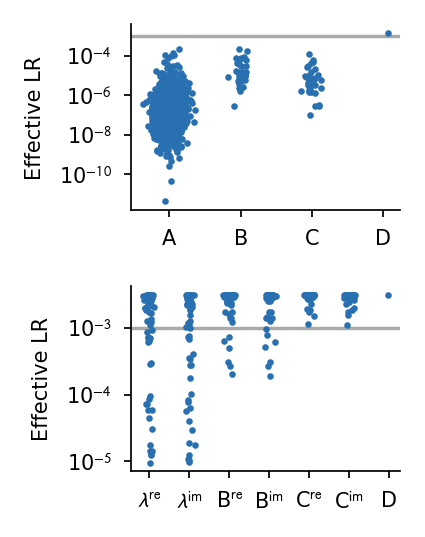

In [3]:
fig, ax = plt.subplots(nrows = 2, figsize=(1.8, 2.25))

# Requires to uncomment "jnp.save(wandb.run.id + "_lr.npy", effective_lr)" in train.py
# and then rename the saved file accordingly.
# RNN run_train.py --compute_hessian=-1 --d_hidden=64 --epochs=100 --force_lsi_min_nu_model=True --lr_base=0.001 --lr_schedule=constant --lsi_T=300 --min_nu=0.99 --model=RNN --batch_size 128
effective_lr = jnp.load("lr_RNN_1.npy", allow_pickle=True)
effective_lr = effective_lr.item()["params"]
data = [
    effective_lr["VmapVmapRNNBase_0"]["A"],
    effective_lr["VmapVmapRNNBase_0"]["B"]["kernel"],
    effective_lr["C"]["kernel"],
    effective_lr["D"]["kernel"]
]
for i, d in enumerate(data):
    if i == 0:
        std = 0.1
    else:
        std = 0.06
    ax[0].scatter(np.random.normal(i+1, std, d.shape), jnp.log10(-d), s=0.8, alpha=1, c="#2970B1")
ax[0].axhline(y=-3, color="#AAAAAA", zorder=-1)
legends = ["A", "B", "C", "D"]
ax[0].set_xticks(range(1, len(legends) + 1), legends)
ax[0].set_yticks([-4, -6, -8, -10], ["10$^\mathrm{-4}$", "10$^\mathrm{-6}$", "10$^\mathrm{-8}$", "10$^\mathrm{-10}$"])
ax[0].set_ylabel("Effective LR")
ax[0].minorticks_off()

# run_train.py --compute_hessian=-1 --d_hidden=64 --epochs=100 --force_lsi_min_nu_model=True --lr_base=0.001 --lr_schedule=constant --lsi_T=300 --min_nu=0.99 --model=LRU --lru_which_gamma none --lru_param default --batch_size 128
effective_lr = jnp.load("lr_c_diag.npy", allow_pickle=True)
effective_lr = effective_lr.item()["params"]
data = [
    effective_lr["lambda"][0],  effective_lr["lambda"][1],
    effective_lr["B_re"], effective_lr["B_im"],
    effective_lr["C_re"], effective_lr["C_im"],
    effective_lr["D"]
]
for i, d in enumerate(data):
    ax[1].scatter(np.random.normal(i+1, 0.06, d.shape), jnp.log10(-d), s=0.8, alpha=1, c="#2970B1")
ax[1].axhline(y=-3, color="#AAAAAA", zorder=-1)
legends = [r"$\lambda^\mathrm{re}$", "$\lambda^\mathrm{im}$", "B$^\mathrm{re}$", r"B$^\mathrm{im}$", r"C$^\mathrm{re}$", r"C$^\mathrm{im}$", "D"]
ax[1].set_xticks(range(1, len(legends) + 1), legends)
ax[1].set_yticks([-3, -4, -5], [r"10$^{-\text{3}}$", "10$^{\mathrm{-4}}$", "10$^{\mathrm{-5}}$"])
ax[1].set_ylabel("Effective LR")
ax[1].minorticks_off()

plt.tight_layout()

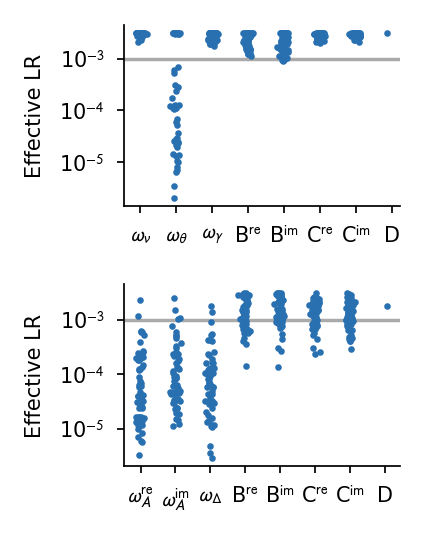

In [7]:
# run_train.py --compute_hessian=-1 --d_hidden=64 --epochs=100 --force_lsi_min_nu_model=True --lr_base=0.001 --lr_schedule=constant --lsi_T=300 --min_nu=0.99 --model=LRU --lru_which_gamma learned --lru_param exp --batch_size 128
effective_lr = jnp.load("lr_LRU.npy", allow_pickle=True)
effective_lr = effective_lr.item()["params"]
data = [
    effective_lr["lambda"][0],  effective_lr["lambda"][1], effective_lr["gamma"],
    effective_lr["B_re"], effective_lr["B_im"],
    effective_lr["C_re"], effective_lr["C_im"],
    effective_lr["D"]
]

fig, ax = plt.subplots(nrows = 2, figsize=(1.8, 2.25))
for i, d in enumerate(data):
    ax[0].scatter(np.random.normal(i+1, 0.06, d.shape), jnp.log10(-d), s=0.8, alpha=1, c="#2970B1")
ax[0].axhline(y=-3, color="#AAAAAA", zorder=-1)
legends = [r"$\omega_\nu$", r"$\omega_\theta$", r"$\omega_\gamma$", r"B$^\mathrm{re}$", r"B$^\mathrm{im}$", r"C$^\mathrm{re}$", r"C$^\mathrm{im}$", "D"]
ax[0].set_xticks(range(1, len(legends) + 1), legends)
ax[0].set_yticks([-3, -4, -5], [r"10$^{-\text{3}}$", "10$^{\mathrm{-4}}$", "10$^{\mathrm{-5}}$"])
ax[0].set_ylabel("Effective LR")
ax[0].minorticks_off()

# run_train.py --compute_hessian=-1 --d_hidden=64 --epochs=100 --force_lsi_min_nu_model=True --lr_base=0.001 --lr_schedule=constant --lsi_T=300 --min_nu=0.99 --model=S4 --s4_shared_Delta false --batch_size 128
effective_lr = jnp.load("lr_S4.npy", allow_pickle=True)
effective_lr = effective_lr.item()["params"]
data = [
    effective_lr["A"][0],  effective_lr["A"][1], effective_lr["Delta"],
    effective_lr["B_re"], effective_lr["B_im"],
    effective_lr["C_re"], effective_lr["C_im"],
    effective_lr["D"]
]

for i, d in enumerate(data):
    ax[1].scatter(np.random.normal(i+1, 0.06, d.shape), jnp.log10(-d), s=0.8, alpha=1, c="#2970B1")
ax[1].axhline(y=-3, color="#AAAAAA", zorder=-1)
legends = [r"$\omega_A^\mathrm{re}$", r"$\omega_A^\mathrm{im}$", r"$\omega_\Delta$", r"B$^\mathrm{re}$", r"B$^\mathrm{im}$", r"C$^\mathrm{re}$", r"C$^\mathrm{im}$", "D"]
ax[1].set_xticks(range(1, len(legends) + 1), legends)
ax[1].set_yticks([-3, -4, -5], [r"10$^{-\text{3}}$", "10$^{\mathrm{-4}}$", "10$^{\mathrm{-5}}$"])
ax[1].set_ylabel("Effective LR")
ax[1].minorticks_off()

plt.tight_layout()